In [70]:
import numpy as np
from numpy.linalg import cholesky
from numpy.linalg import eigvals
from numpy.linalg import inv

import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [71]:
# defines a block matrix - useful for constructing 4-d correlation matrix 
class block_matrix:
    
    # initialize zero matrix
    def __init__(self, n, m, p, q):
        self.matrix = np.zeros((n*p, m*q))
     
    # set element i, j with matrix a
    def set_element(self, i, j, a):
        p, q = np.shape(a)
        for k in range(p):
            for l in range(q):
                self.matrix[p*i+k, q*j+l] = a[k, l]
    
    # print the matrix nicely
    def __str__(self):
        return_string = ''
        format_string = '{:.2e}'
        m, n = np.shape(self.matrix)
        for i in range(m):
            for j in range(n):
                return_string += format_string.format(self.matrix[i, j]) + ' '
            return_string += '\n'
        return return_string

In [140]:
# defines a gaussian process
class gp:
    
    # initialize with a kernel and mean value (not a function, yet...)
    def __init__(self, kernel, mean):
        self.kernel = kernel
        self.mean = mean
    
    # generate the covariance matrix in the 1d case
    def _make_covariance_matrix(self, x):
        n = len(x)
        sigma = np.matrix(np.zeros((n, n)))
        for i in range(n):
            for j in range(i+1):
                sigma[i, j] = self.kernel(x[i] - x[j])
                sigma[j, i] = sigma[i, j]
        return sigma
    
    # generate the covariance matrix in the 2d case. subcov is the covariance matrix for the second dimension. 
    def _make_covariance_matrix_2d(self, x, subcov):
        n = len(x)
        sigma = block_matrix(n, n, len(subcov), len(subcov))
        for i in range(n):
            for j in range(i+1):
                sigma.set_element(i, j, subcov*self.kernel(x[i]-x[j]))
                if i is not j:
                    sigma.set_element(j, i, subcov.T*self.kernel(x[i]-x[j]))
        return sigma.matrix
    
    # sample the gaussian process in 1 or 2 dimensions. 
    def sample(self, x, two_d=False, subcov=np.matrix([[2, 1], [1, 2]])):
        
        def concat(x, n):
            a = x
            for i in range(n-1):
                a = np.concatenate((a, x))
            return a
        
        if two_d:
            sigma = self._make_covariance_matrix_2d(x, subcov)
            n_samples = len(subcov)
            x = concat(x, n_samples)
            n = len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            samp = np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]
            ret = []
            for i in range(n_samples):
                ret.append(samp[i::n_samples])
            return ret
        else:
            sigma = self._make_covariance_matrix(x)
            n = len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            return np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]

# defines the kernel for the gaussian process
class kernel:
    
    # empty init function
    def __init__(self):
        return
     
    # apparently with zero white noise the covariance matrix may not be positive definite...  
    # square exponential kernel with white noise
    def exp_sq_kernel(l, sig, wn=1e-12): 
        def k(r):
            return (sig**2)*np.exp(-(r**2)/(2*(l**2))) + (r == 0)*wn
        return k
    
    # white noise adds sigma to diagonal
    def white_noise_kernel(self, white_noise):
        def k(r):
            if r == 0:
                return white_noise
        return k


In [169]:
# define the kernel function
k = kernel.exp_sq_kernel(1, 1, wn=0.05)
# initialize the gaussian process with kernel function k and mean of 1
g = gp(k, 1)

# times to sample at
t = np.linspace(0, 100, 1000)

# off-diagonal correlation in second dimension. If exp sq kernel, 1.5=sigma^2, 1.2 = sigma^2*np.exp(-d/2), etc. where 
# d is the distance between the time series in wavelength space. 
sig = 2
c1 = 1.5
c2 = 1
# on-diagonal correlation in second dimension
# Note: c must be greater than sigma for the correlation matrix to be positive definite (which it needs to be).

# sample the GP
x1, x2, x3 = g.sample(t, two_d=True, subcov=np.matrix([[sig, c1, c2],[c1, sig, c1], [c2, c1, sig]]))

Text(0,0.5,'flux (?) (dependent variable)')

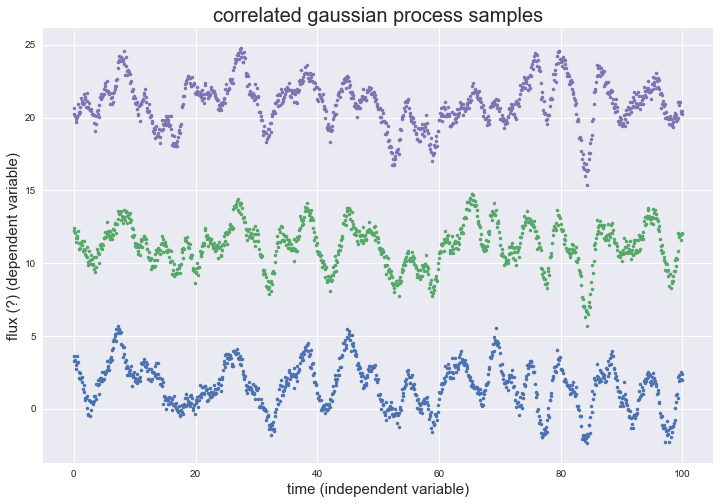

In [171]:
# plot the samples
fig = pl.figure(figsize=(12, 8))

# odd elements are one function and even elements the other. 
#x1 = x[::2]
#x2 = x[1::2]

#pl.plot(t, x2 + 10, '-')
#pl.plot(t, x1, '-')
pl.plot(t, x1, '.', alpha=1, color=palette[0])
pl.plot(t, x2 + 10, '.', alpha=1, color=palette[1])
pl.plot(t, x3 + 20, '.', alpha=1, color=palette[3])
pl.title('correlated gaussian process samples', size=20)
pl.xlabel('time (independent variable)', size=15)
pl.ylabel('flux (?) (dependent variable)', size=15)

In [135]:
sig = 1.2
c1 = 1.1
c2 = 1
a = np.matrix([[sig, c1, c2],[c1, sig, c1], [c2, c1, sig]])

In [136]:
a

matrix([[1.2, 1.1, 1. ],
        [1.1, 1.2, 1.1],
        [1. , 1.1, 1.2]])